In [260]:
import numpy as np
import pandas as pd
import plotnine as pn

import matplotlib.pyplot as plt

from sciterra import Atlas, Cartographer
from sciterra.vectorization import SciBERTVectorizer,GPT2Vectorizer

In [261]:
# atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=Word2Vec/center=hafenLowredshiftLymanLimit2017"
atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=SciBERT/center=Imeletal2022"
# atlas_dir = "/Users/nathanielimel/uci/projects/citesim/outputs/librarian=S2/vectorizer=GPT2/center=hafenLowredshiftLymanLimit2017"

In [262]:
atl = Atlas.load(atlas_dir)
len(atl)

10251

In [263]:
print(atl.history.keys())
kernels = atl.history['kernel_size']
print(kernels.shape)
len(atl.history['pubs_per_update'])

dict_keys(['pubs_per_update', 'kernel_size'])
(10251, 55)


56

In [264]:
convergence_degrees = list(range(kernels.shape[1])) # the max convergence iteration

In [265]:
np.set_printoptions(suppress=True)
np.array([np.mean(kernels[:, i]) for i in range(kernels.shape[1])])

array([-0.99756121, -0.9662472 , -0.92995805, -0.89718076, -0.84820993,
       -0.80440933, -0.7389523 , -0.65437518, -0.61837869, -0.61125744,
       -0.6055019 , -0.59964881, -0.5920398 , -0.58043118, -0.57389523,
       -0.57057848, -0.56248171, -0.55077553, -0.52570481, -0.50209736,
       -0.44883426, -0.38688908, -0.32445615, -0.23490391, -0.09228368,
        0.08955224,  0.25548727,  0.44239586,  0.61847625,  0.7560238 ,
        0.95180958,  1.16135011,  1.39986343,  1.64159594,  1.86147693,
        2.2307092 ,  2.59789289,  3.0637011 ,  3.41293532,  3.55311677,
        3.61115989,  3.76470588,  3.91561799,  4.02272949,  4.25002439,
        4.65174129,  4.77377817,  4.89513218,  5.3609404 ,  7.0335577 ,
        8.15725295,  9.76655936, 16.0068286 , 33.08252853, 67.42278802])

In [266]:
df_kernel_evolution = pd.DataFrame(
    [
        (
            i+1, 
            np.mean(kernels[:, i]), 
            np.sum(kernels[:, i] >= 1),
            np.sum(kernels[:, i] >= 10),
            np.sum(kernels[:, i] >= 100),
            np.sum(kernels[:, i] >= 1000),
        ) 
        for i in range(kernels.shape[1])],
    columns=[
        "expansion", 
        "avg_converged_kernel_size", 
        "num_converged_for_1",
        "num_converged_for_10",
        "num_converged_for_100",
        "num_converged_for_1000",
    ],
)
# df_kernel_evolution

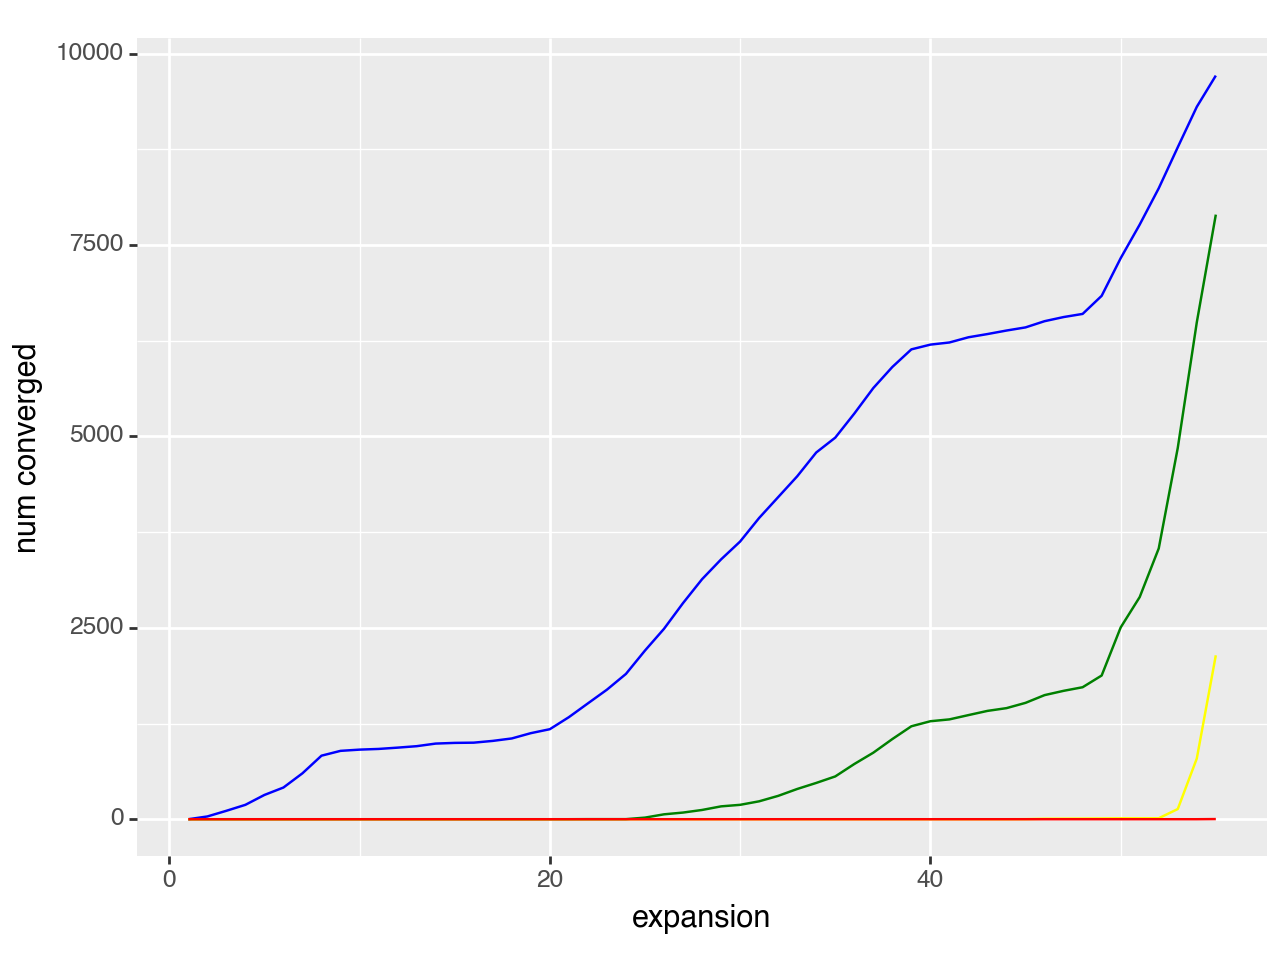

<Figure Size: (640 x 480)>

In [267]:
(
    pn.ggplot(
        df_kernel_evolution, 
        pn.aes(
            x="expansion", 
            # y="avg_converged_kernel_size",
            # y="num_converged_for_16",
        ),
    )
    # + pn.geom_point()
    + pn.geom_line(pn.aes(y="num_converged_for_1"), color="blue")
    + pn.geom_line(pn.aes(y="num_converged_for_10"), color="green")
    + pn.geom_line(pn.aes(y="num_converged_for_100"), color="yellow")
    + pn.geom_line(pn.aes(y="num_converged_for_1000"), color="red")
    + pn.ylab("num converged")
)

In [268]:
# Why not just choose the very last index always?

In [269]:
from collections import Counter
fields = Counter([field for pub in atl.publications.values() for field in pub.fields_of_study])
fields

Counter({'Linguistics': 10251,
         'Psychology': 2897,
         'Computer Science': 2668,
         'Sociology': 1536,
         'Education': 1190,
         'Mathematics': 887,
         'History': 754,
         'Medicine': 628,
         'Philosophy': 556,
         'Political Science': 330,
         'Geography': 141,
         'Art': 121,
         'Engineering': 91,
         'Business': 57,
         'Physics': 36,
         'Economics': 25,
         'Law': 24,
         'Biology': 18,
         'Geology': 8,
         'Chemistry': 6,
         'Environmental Science': 6,
         'Materials Science': 6})

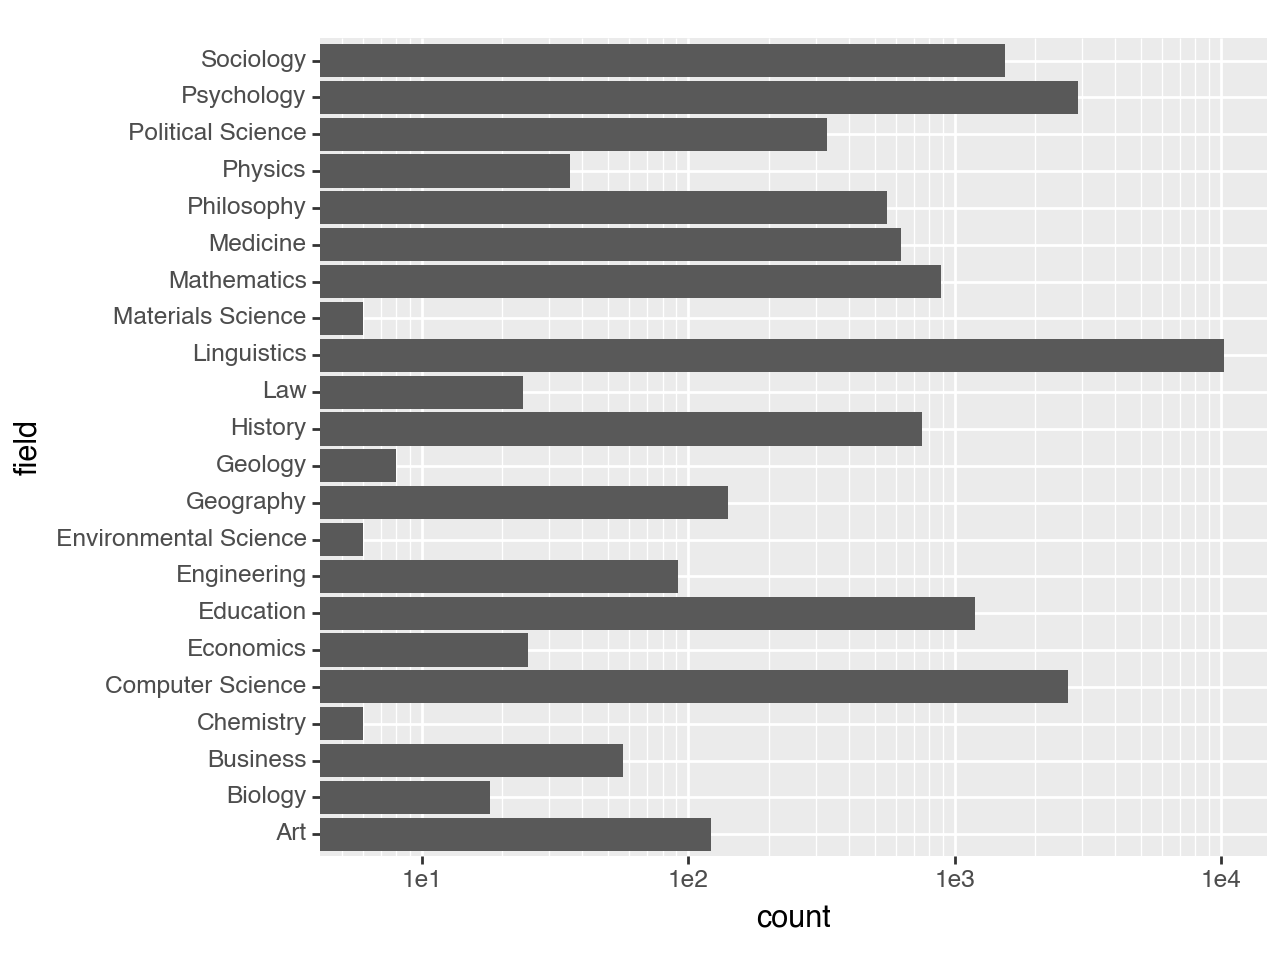

<Figure Size: (640 x 480)>

In [270]:
(
    pn.ggplot(
        data = pd.DataFrame(
            data=[(field, count) for field,count in fields.items()],
            columns=["field", "count"],
        ),
        mapping=pn.aes(x="field", y="count"),
    )
    + pn.scale_y_log10()
    + pn.geom_col()
    + pn.coord_flip()
)

In [271]:
# con_d = int(kernels.shape[1]/2)
# print(f"Setting convergence degree to len(history)/2 = {con_d}.\n")

# NOTE: idea: what if we choose the con_d s.t. it's the first update where the _avg_ kernel size is >= kernel_size?

con_d = 1 # 1 = very last
kernel_size =  16 # TODO: find a principled way of selecting this value.

# Get all publications that have not changed neighborhoods up to kernel_size for the last con_d updates
converged_filter = kernels[:, -con_d] >= kernel_size
ids = np.array(atl.projection.index_to_identifier)
converged_pub_ids = ids[converged_filter]

[atl[id].title for id in converged_pub_ids][:10]

['Modal semantic universals optimize the simplicity/informativeness trade-off',
 'Predicting Pragmatic Reasoning in Language Games',
 'The Expression of Modality in Tlingit: A Paucity of Grammatical Devices1',
 'A Variable-Force Variable-Flavor Attitude Verb in Koryak∗',
 'Indefinite Pronouns Optimize the Simplicity/Informativeness Trade‐Off',
 'Reverse-engineering the language of thought: A new approach',
 'Efficient compression in color naming and its evolution',
 'Variable Modality in Pintupi-Luritja Purposive Clauses',
 'The forms and meanings of grammatical markers support efficient communication',
 'A Database for Modal Semantic Typology']

In [272]:
# Filter to physics!
# Filter to linguistics!
converged_pub_ids = [id for id in converged_pub_ids if "Linguistics" in atl[id].fields_of_study]
len(converged_pub_ids)

6962

In [273]:
crt = Cartographer(
    vectorizer=SciBERTVectorizer()
    # vectorizer=GPT2Vectorizer(),
)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: a3c2c933-c5bc-458a-8d6f-1c371ac766a5)')' thrown while requesting HEAD https://huggingface.co/allenai/scibert_scivocab_uncased/resolve/main/tokenizer_config.json


Using device: cpu.


In [274]:
measurements = crt.measure_topography(
    atl, 
    ids=converged_pub_ids,
    metrics=["density", "edginess"], 
    kernel_size=kernel_size,
)

computing cosine similarity for 6962 embeddings with batch size 1000.


100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


Computing ['density', 'edginess'] for 6962 publications.


invalid value encountered in divide


In [275]:
# get citations
citations_per_year = [ 
    atl[id].citation_count / (2023 - atl[id].publication_date.year) if (atl[id].publication_date.year < 2023 and atl[id].citation_count is not None) else 0.
    for id in converged_pub_ids
]

In [276]:
df = pd.DataFrame(
    measurements,
    columns=["density", "edginess"],
)
df["citations_per_year"] = citations_per_year

df = df[~np.isinf(df["density"])] # drop infs which occur for BOW vectorizer

df.dropna(inplace=True, ) 

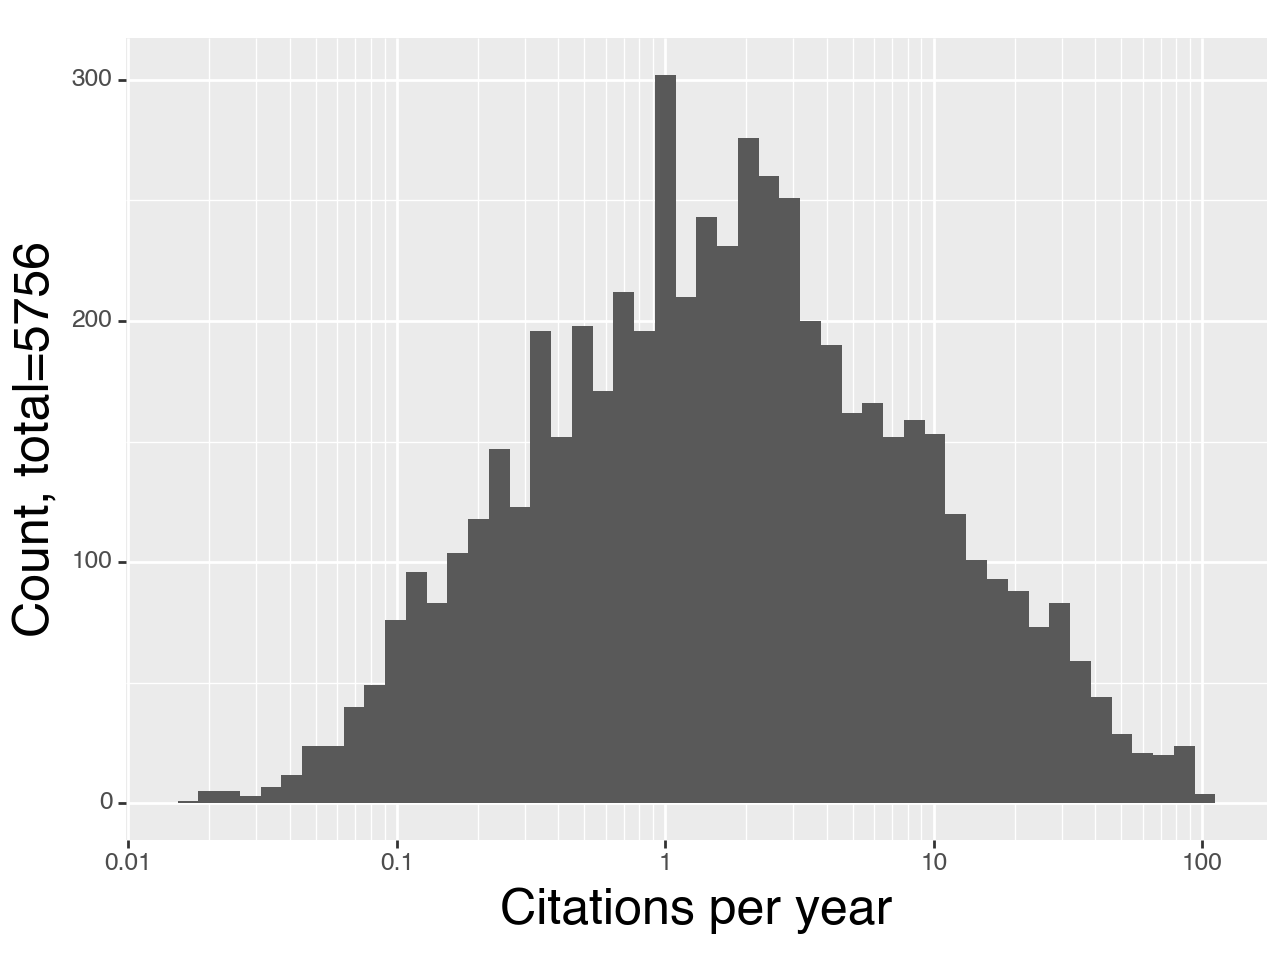

<Figure Size: (640 x 480)>

In [277]:
df_f = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= 100.)]

(
    pn.ggplot(
        # df,
        df_f,
        mapping=pn.aes(x="citations_per_year")
    )
    + pn.geom_histogram(bins=50)
    + pn.scale_x_log10()
    + pn.xlab("Citations per year")
    + pn.ylab(f"Count, total={len(df_f)}")
    + pn.theme(
        axis_title=pn.element_text(size=18)
    )
)

In [278]:
# How many points are N cpy and below?
N = df["citations_per_year"].mean() + 1*df["citations_per_year"].std()
cpy = df["citations_per_year"]
print(f"{len(cpy[cpy <= N])}/{len(cpy)} = ({len(cpy[cpy <= N]) / len(cpy) * 100} %) of publications received <= {N} cpy")

6581/6921 = (95.0874151134229 %) of publications received <= 26.68416222905713 cpy


In [279]:
# How many points are M density and below
M = df["density"].mean() + 1*df["density"].std()
M = 60
rho = df["density"]
print(f"{len(rho[rho <= N])}/{len(rho)} = ({len(rho[rho <= M]) / len(rho) * 100} %) of publications have <= {M} density")

1563/6921 = (99.79771709290564 %) of publications have <= 60 density


In [280]:
df_filtered = df[(df["citations_per_year"] > 0) & (df["citations_per_year"] <= N)]
df_filtered = df_filtered[df_filtered["density"] <= M]

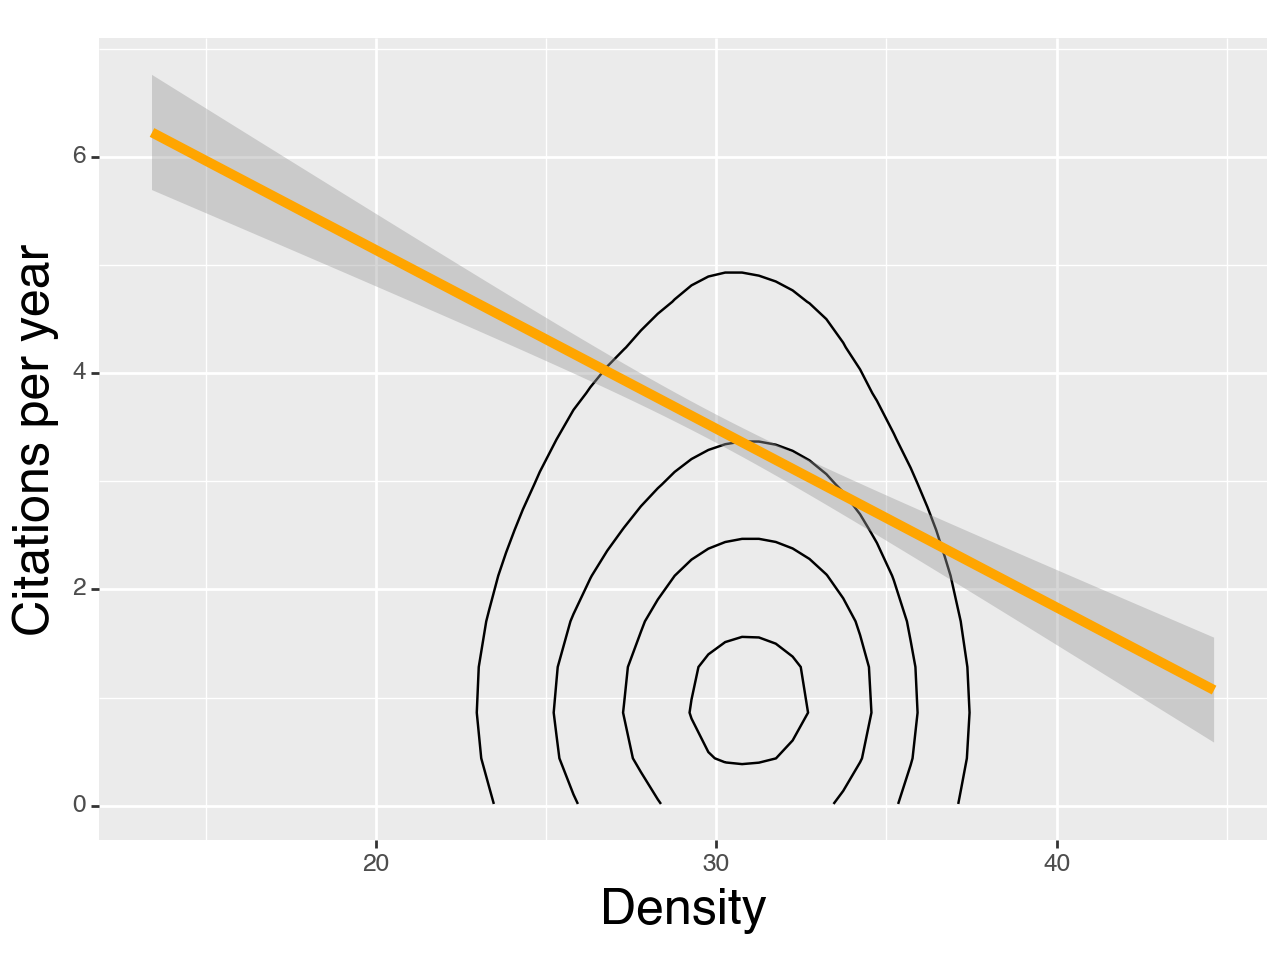

<Figure Size: (640 x 480)>

In [284]:
(
    pn.ggplot(
        df_filtered,
        mapping=pn.aes(
            x="density", 
            # x="edginess",
            y="citations_per_year",
        )
    )
    # + pn.geom_point(
    #     alpha=0.2,
    # )
    + pn.stat_density_2d(pn.aes(
        fill=pn.mapping.after_stat('count'),
    ))
    + pn.xlab("Density")
    # + pn.xlab("Asymmetry")
    + pn.ylab("Citations per year")
    + pn.geom_smooth(color="orange", size=2)
    + pn.theme(
        # axis_title_y=pn.element_blank(),
        axis_title=pn.element_text(size=18),
    )
)

TODO: dump the data to a csv, and see if get different results in R

In [ ]:
df_filtered.to_csv("df_filtered.csv")

Connor feedback:

- Use a nonlinear regression, since that's obviously the relationship
- You can use likelihood ratio test, AIC and BIC, though the former is probably fine and easiest since latter requires params to be shared across models. 
- Density sweet spot is intuitive, but no relationship at all is interesting too!

Try to compute the running median

In [ ]:
# TODO: write it out by hand.